In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd

In [3]:
%run -i columns.py
%run -i helper_functions.py

In [5]:
df = pd.read_csv('tmp/developing_countries.csv')
df.head()

,Country,Country code,Year,Happiness rank,Happiness score,GDP per capita,Social support,Life expectancy,Freedom,Perceptions of corruption,...,Employment in industry (% of total employment) (modeled ILO estimate),Employment in services (% of total employment) (modeled ILO estimate),Forest area (% of land area),Individuals using the Internet (% of population),"Industry (including construction), value added per worker (constant 2010 US$)","Manufacturing, value added (% of GDP)",Medium and high-tech industry (% manufacturing value added),"Railways, goods transported (million ton-km)","Railways, passengers carried (million passenger-km)",Urban population (% of total)
0,Afghanistan,AFG,2015,153,3.575,0.319820,0.302850,0.303350,0.23414,0.097190,...,17.646999,43.674999,2.067825,8.260000,2079.555916,11.420006,9.507434,NaN,NaN,24.803
1,Afghanistan,AFG,2016,154,3.360,0.382270,0.110370,0.173440,0.16430,0.071120,...,17.424999,43.756001,2.067825,10.595726,1999.566153,11.370465,NaN,NaN,NaN,25.020
2,Afghanistan,AFG,2017,141,3.794,0.401477,0.581543,0.180747,0.10618,0.061158,...,17.457001,43.768002,NaN,11.447688,1923.393447,11.102526,NaN,NaN,NaN,25.250
3,Afghanistan,AFG,2018,145,3.632,0.332000,0.537000,0.255000,0.08500,0.036000,...,17.596001,43.816002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Albania,ALB,2015,95,4.959,0.878670,0.804340,0.813250,0.35733,0.064130,...,18.617001,40.020000,28.156934,63.252933,13648.254549,5.671519,6.690696,NaN,NaN,57.434


In [4]:
threshold = 0.6
df_thresh = df.dropna(axis=1, thresh=int(df.shape[0] * threshold))
df_impute = df_thresh.fillna(df_thresh.mean())
df_impute.describe()

C:\Users\rekak\AppData\Local\Temp\ipykernel_13724\3317798125.py:3: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_impute = df_thresh.fillna(df_thresh.mean())


,Year,Happiness rank,Happiness score,GDP per capita,Social support,Life expectancy,Freedom,Perceptions of corruption,Generosity,Dystopia residual,"Agriculture, forestry, and fishing, value added per worker (constant 2010 US$)","Air transport, passengers carried","Commercial bank branches (per 100,000 adults)",Employment in agriculture (% of total employment) (modeled ILO estimate),Employment in industry (% of total employment) (modeled ILO estimate),Employment in services (% of total employment) (modeled ILO estimate),Individuals using the Internet (% of population),"Industry (including construction), value added per worker (constant 2010 US$)","Manufacturing, value added (% of GDP)",Urban population (% of total)
count,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,4.570000e+02,4.570000e+02,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000
mean,2016.494530,92.221007,5.022313,0.795687,0.974366,0.512896,0.389140,0.104963,0.214298,2.030955,2.076123e+04,1.814317e+07,13.890841,31.216241,19.793201,48.990571,42.805461,23036.702831,12.666669,55.169177
std,1.118266,39.978960,0.968432,0.365876,0.323990,0.213048,0.150710,0.082750,0.120375,0.585681,1.515434e+05,4.409611e+07,9.118862,21.638516,8.503950,15.875213,21.451886,25886.912377,4.922361,18.276113
min,2015.000000,12.000000,2.693000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001990,0.291000,1.836964e+02,8.990000e+02,0.454000,0.058000,2.086000,5.957000,1.880000,639.511832,1.768629,12.078000
25%,2015.000000,59.000000,4.308000,0.493000,0.777110,0.345780,0.288516,0.054000,0.134000,1.683024,1.852477e+03,1.285642e+06,8.577994,13.104000,13.222000,38.425999,25.664768,9499.450371,10.818186,45.862000
50%,2016.000000,94.000000,5.082000,0.860860,1.003187,0.579000,0.406720,0.085460,0.200000,1.980000,6.568982e+03,1.328510e+07,13.890841,28.452999,19.929001,50.950001,42.805461,23036.702831,12.666669,55.169177
75%,2017.000000,127.000000,5.822000,1.061660,1.226680,0.678060,0.499000,0.128000,0.264750,2.393740,2.076123e+04,1.814317e+07,14.056147,44.521999,25.368999,61.146000,57.272244,23036.702831,13.731697,65.850000
max,2018.000000,158.000000,7.226000,1.870766,1.584000,0.965380,0.724000,0.551910,0.838075,3.837720,2.893900e+06,5.512345e+08,70.561644,91.957001,54.555000,77.537003,97.999989,180220.430997,38.334660,100.000000


## Using sgd data to predict wh data

In [5]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_impute, test_size=0.2)

In [6]:
def split_X_Y(df: pd.DataFrame):
    cols = set(df.columns)
    sgd_cols = set(URBANIZATION_INDICATORS + ANTI_URBANIZATION_INDICATORS)
    mutual = cols.intersection(sgd_cols)
    sgd = df[list(mutual)]

    wh_cols = list(cols - sgd_cols)
    wh = df[wh_cols].drop(['Country', 'Happiness rank', 'Happiness score', 'Country code', 'Year'], axis=1)

    return sgd, wh

In [7]:
from sklearn import preprocessing
def norm_transform_gen(data: np.ndarray):
    scaler = preprocessing.MinMaxScaler().fit(data)
    # scaler = preprocessing.StandardScaler().fit(data)
    return scaler

In [8]:
X, Y = split_X_Y(train)

In [9]:
X

,Individuals using the Internet (% of population),Employment in agriculture (% of total employment) (modeled ILO estimate),Employment in industry (% of total employment) (modeled ILO estimate),"Air transport, passengers carried","Agriculture, forestry, and fishing, value added per worker (constant 2010 US$)","Commercial bank branches (per 100,000 adults)","Manufacturing, value added (% of GDP)",Urban population (% of total),Employment in services (% of total employment) (modeled ILO estimate),"Industry (including construction), value added per worker (constant 2010 US$)"
46,42.805461,41.401001,19.403999,1.814317e+07,20761.228907,13.890841,12.666669,55.169177,39.195999,23036.702831
425,42.805461,15.332000,24.256001,1.814317e+07,20761.228907,13.890841,12.666669,55.169177,60.411999,23036.702831
351,21.690264,33.333000,12.992000,1.153550e+05,2223.188852,4.925039,17.043055,45.862000,53.674999,10160.359795
13,13.000000,49.442001,8.233000,1.482546e+06,1552.171479,10.286108,6.752681,64.149000,42.324001,58156.465046
267,42.805461,32.182999,16.625999,1.814317e+07,20761.228907,13.890841,12.666669,55.169177,51.192001,23036.702831
...,...,...,...,...,...,...,...,...,...,...
367,92.843026,4.818000,24.993000,7.685954e+07,19126.126853,16.257475,26.781828,81.562000,70.189003,68208.640436
417,42.805461,22.775999,33.706001,1.814317e+07,20761.228907,13.890841,12.666669,55.169177,43.518002,23036.702831
322,42.805461,27.455000,15.644000,1.814317e+07,20761.228907,13.890841,12.666669,55.169177,56.901001,23036.702831
362,51.919116,5.613000,23.827999,1.888290e+07,10836.264999,10.451580,12.002993,64.828000,70.558998,28331.481945


In [10]:
Y

,Generosity,Freedom,Life expectancy,Perceptions of corruption,Dystopia residual,Social support,GDP per capita
46,0.16300,0.44000,0.24000,0.06700,2.48100,0.37200,0.37800
425,0.18700,0.16300,0.60900,0.01100,0.92700,1.41300,0.79300
351,0.20843,0.36772,0.43540,0.10713,1.44395,0.97619,0.36498
13,0.12071,0.00589,0.04991,0.08434,2.09459,0.66366,0.84731
267,0.17100,0.23200,0.62000,0.00000,2.65900,1.30100,0.65700
...,...,...,...,...,...,...,...
367,0.18824,0.25168,0.88645,0.07716,2.35015,0.72194,1.35948
417,0.19900,0.41700,0.51700,0.03700,1.91700,1.53300,1.01600
322,0.09200,0.53000,0.67400,0.03400,2.15000,1.24900,0.93400
362,0.11973,0.33207,0.27688,0.08884,1.71956,1.18468,0.92049


In [11]:
X_scaler = norm_transform_gen(X.to_numpy())
Y_scaler = norm_transform_gen(Y.to_numpy())
X_scaled = X_scaler.transform(X.to_numpy())
Y_scaled = Y_scaler.transform(Y.to_numpy())

In [12]:
class FeaturePredictNN(nn.Module):
    def __init__(self, in_features, out_features, hidden_size=20) -> None:
        super().__init__() 
        self.linear1 = nn.Linear(in_features=in_features, out_features=hidden_size)
        self.sig1 = nn.Sigmoid()
        self.linear2 = nn.Linear(in_features=hidden_size, out_features=out_features)
    
    def forward(self, x):
        hidden = self.sig1(self.linear1(x))
        out = self.linear2(hidden)
        return out
        

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X = torch.Tensor(X_scaled).to(device)
Y = torch.Tensor(Y_scaled).to(device)

In [14]:
model = FeaturePredictNN(10, 7).to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
epoches = 200

In [15]:
X_test, Y_test = split_X_Y(test)
X_test = X_scaler.transform(X_test.to_numpy())
Y_test = Y_scaler.transform(Y_test.to_numpy())
X_test = torch.Tensor(X_test).to(device)
Y_test = torch.Tensor(Y_test).to(device)
mse_loss = nn.MSELoss()

In [16]:
losses = []
test_losses = []
for epoch in range(1, epoches+1):
    inputs = X
    targets = Y

    optimizer.zero_grad()
    
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    test_outputs = model(X_test)
    test_loss = mse_loss(test_outputs, Y_test)
    test_losses.append(test_loss.item())

    losses.append(loss.item())

    if epoch % (epoches//10) == 0:
        print(f"loss: {loss.item()}") 

loss: 0.042192574590444565
loss: 0.03323248773813248
loss: 0.03332106024026871
loss: 0.033112406730651855
loss: 0.0329822339117527
loss: 0.03289321810007095
loss: 0.032810553908348083
loss: 0.032728370279073715
loss: 0.03264622017741203
loss: 0.03256409987807274


In [17]:
import matplotlib.pyplot as plt

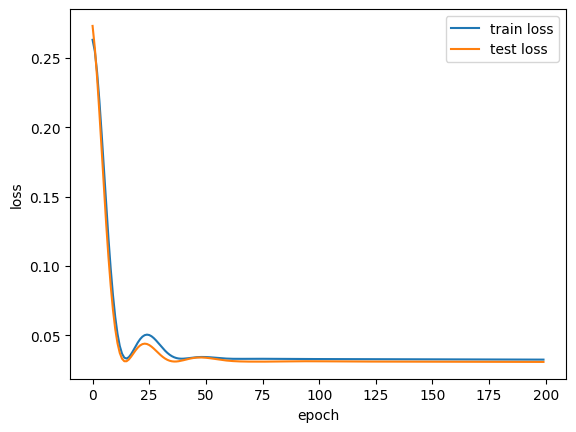

In [18]:
plt.plot(losses)
plt.plot(test_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train loss', 'test loss'])

In [19]:
torch.save(model.state_dict(), 'weights/fenn.pt')

In [20]:
X_max = X_scaler.data_max_.copy()
X_min = X_scaler.data_min_.copy()

In [ ]:
X_end = X_max.copy()
tmp = X_min.copy()
tmp[1:] = 0
print(tmp)

X_start = X_end - tmp

print(X_end)
print(X_start)

X_original = np.linspace(X_start, X_end, 50)
X_scaled = X_scaler.transform(X_original)

In [ ]:
y_out = model(torch.Tensor(X_scaled).to(device))

In [ ]:
print(y_out.shape)

In [ ]:
X_plot = X_original
y_plot = Y_scaler.transform(y_out.cpu().detach().numpy())

In [ ]:
plt.plot(X_plot[:,0], y_plot[:, 0])
plt.plot(X_plot[:,0], y_plot[:, 1])
plt.plot(X_plot[:,0], y_plot[:, 2])
plt.plot(X_plot[:,0], y_plot[:, 3])
plt.plot(X_plot[:,0], y_plot[:, 4])
plt.plot(X_plot[:,0], y_plot[:, 5])
plt.plot(X_plot[:,0], y_plot[:, 6])

In [ ]:
X, Y = split_X_Y(train)
X_columns = X.columns
y_columns = Y.columns



In [ ]:
from math import ceil
def one2many(X, Y, X_scaler=X_scaler, Y_scaler=Y_scaler):
    # for each factors in sgd data, there will be two values in side in array form
    # eg:
    # res = [[X_plot, Y_plot], ..., [X_plot, Y_plot]]
    res = []

    X_max = X_scaler.data_max_.copy()
    X_min = X_scaler.data_min_.copy()

    for i in range(X.shape[1]):
        X_end = X_max.copy()
        tmp = X_min.copy()
        tmp[i+1:] = 0

        X_start = X_end - tmp

        X_original = np.linspace(X_start, X_end, 50)
        X_scaled = X_scaler.transform(X_original)

        y_out = model(torch.Tensor(X_scaled).to(device))

        X_plot = X_scaled
        y_plot = Y_scaler.transform(y_out.cpu().detach().numpy())

        res.append([X_plot[:, i], y_plot])
    
    return res

# data is in form one2many returns
def plotDiff(data, x_labels, y_labels, n_cols=3, figure_size=(3, 3)):
    n_rows = ceil(len(y_labels) / n_cols)
    figure, axis = plt.subplots(n_rows, n_cols)

    figure.set_size_inches(figure_size)
    figure.tight_layout(pad=5.0)

    for i in range(len(y_labels)):
        row = i // n_cols
        col = i % n_cols

        for j in range(len(x_labels)):
            X2plot = data[j][0]
            Y2plot = data[j][1]
            axis[row, col].plot(X2plot, Y2plot[:, i])

            axis[row, col].set_xlabel('value of sgd factors')
            axis[row, col].set_ylabel(y_labels[i])

    
    for i in range(len(y_labels), n_rows*n_cols):
        row = i // n_cols
        col = i % n_cols
        axis[row, col].axis('off')
    
    figure.legend(x_labels, loc='lower right')
    return figure

In [ ]:
res = one2many(X, Y)
plotDiff(res, X_columns, y_columns, figure_size=(15, 12))

In [ ]:
for i in range(len(X_columns)):
    X2plot = res[i][0]
    Y2plot = res[i][1]

    plt.plot(X2plot, Y2plot[:, 1])

plt.legend(X_columns)

In [ ]:
plt.plot(res[0][0], res[0][1][:, 1])

## Happiness Score model

In [ ]:
wh_df = df.iloc[:, :12]
print(wh_df.isna().sum().sum())
wh_df_numeric= wh_df.drop(['Country', 'Country code', 'Year', 'Happiness rank'], axis=1)
wh_df_numeric.head()

In [ ]:
train, test = train_test_split(wh_df_numeric, test_size=0.1)
print(train.shape)
print(test.shape)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
def transform(data):
    X_origin = data.drop('Happiness score', axis=1).to_numpy()
    poly_transformer = PolynomialFeatures(degree=2, include_bias=False)
    X_poly = poly_transformer.fit_transform(X_origin)
    return X_poly, data['Happiness score'].to_numpy().reshape((-1, 1))

In [ ]:
X_train, y_train = transform(train)
print(X_train.shape)
print(y_train.shape)

In [ ]:
from sklearn.linear_model import LinearRegression

poly_model = LinearRegression()
poly_model.fit(X_train, y_train)

In [ ]:
X_test, y_test = transform(test)
y_preds = poly_model.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error

mae = mean_squared_error(y_test, y_preds)
print(mae)

## Urbanization indicators modeling

In [ ]:
developed_countries = pd.read_csv(f'./dataset/developed_countries.csv')
developed_countries['Country code'] = get3countryCode(developed_countries['Country'])

In [ ]:
sgd = pd.read_csv('./dataset/world_happiness/sustainable_develop_goals/sdg-csv-zip-7-mb-/SDGData.csv')
sgd_urban = sgd[sgd['Indicator Name'].isin(
    URBANIZATION_INDICATORS + ANTI_URBANIZATION_INDICATORS
)].iloc[:, :33].sort_values(by=['Country Name', 'Indicator Name']).reset_index(drop=True)
print(sgd_urban.shape)
sgd_urban

In [ ]:
sgd_urban.isna().sum(axis=1)

In [ ]:
sgd_urban[sgd_urban['Country Name'] == 'Zimbabwe'].isna().sum().sum()

In [ ]:
shape = sgd_urban[sgd_urban['Country Name'] == 'Zimbabwe'].shape
cell_total = shape[0] * shape[1]
print(cell_total)

In [ ]:
### time series data preparing
row = sgd_urban.iloc[4, :]
def impute_row(row):
    row_numeric = row.iloc[4:].to_numpy()

    row_numeric.shape

    i = 0
    while i < row_numeric.shape[0] and np.isnan(row_numeric[i]):
        row_numeric[i] = 0
        i += 1

    j = i + 1

    while i < row_numeric.shape[0]:
        while i < row_numeric.shape[0] and not np.isnan(row_numeric[i]):
            i += 1

        if i == row_numeric.shape[0]:
            break
        
        j = i
        i -= 1 

        while j < row_numeric.shape[0] and np.isnan(row_numeric[j]):
            j += 1
        
        # means all the values behind index i is null
        if j == row_numeric.shape[0]:
            for index in range(i+1, j):
                row_numeric[index] = row_numeric[i]
        else:
            for index in range(i+1, j):
                row_numeric[index] = row_numeric[i] + (row_numeric[j] - row_numeric[i]) * (index-i) / (j-i)
    
    row.iloc[4:] = row_numeric
        
    return row

impute_row(row)

In [ ]:
sgd_imputed = sgd_urban.apply(impute_row, axis=1)

In [ ]:
sgd_imputed

In [ ]:
indicators_ranges = {}

for indicator in URBANIZATION_INDICATORS + ANTI_URBANIZATION_INDICATORS:
    indicator_max = sgd_imputed[sgd_imputed['Indicator Name'] == indicator].iloc[:, 4:].max().max()
    indicator_min = sgd_imputed[sgd_imputed['Indicator Name'] == indicator].iloc[:, 4:].min().min()
    indicators_ranges[indicator] = {
        "max": indicator_max,
        "min": indicator_min
    }

indicators_ranges

indicator = 'Air transport, freight (million ton-km)'

In [ ]:
row = sgd_imputed.iloc[0, :]
def rescale_row(row):
    row_numeric = row.iloc[4:].to_numpy()
    indicator = row['Indicator Name']

    row_numeric -= indicators_ranges[indicator]['min']
    row_numeric /= indicators_ranges[indicator]['max']
    row_numeric

    row.iloc[4:] = row_numeric

    return row

In [ ]:
sgd_rescaled = sgd_imputed.apply(rescale_row, axis=1)

In [ ]:
sgd_rescaled

In [ ]:
## Model - encoder and decoder manner
import torch.nn as nn
class IndicatorPredictNN(nn.Module):
    def __init__(self, indicators_dim, hidden_size, rnn_hidden, batch_size, rnn_layers=2) -> None:
        super().__init__()

        self.batch_size = batch_size
        self.rnn_layers = rnn_layers
        self.rnn_hidden = rnn_hidden

        self.linear = nn.Linear(indicators_dim, hidden_size)
        self.rnn = nn.LSTM(hidden_size, rnn_hidden, rnn_layers, batch_first=True)

        self.linear2 = nn.Linear(rnn_hidden, indicators_dim)
    
    def init_hidden(indicators_dim, hidden_dim):
        pass
    
    def forward(self, x):
        out = self.linear(x) 
        h0, c0 = self.init_hidden(self.batch_size, self.rnn_layers, self.rnn_hidden)

        out, _ = self.rnn(out, (h0, c0))
        out = self.linear2(out[:, -1, :])

        return out


    def init_hidden(self, batch_size, rnn_layers, rnn_hidden, bidirection=False, device=torch.device("cuda")):
        h0 = torch.randn((1+bidirection)*rnn_layers, batch_size, rnn_hidden, device=device)
        c0 = torch.randn((1+bidirection)*rnn_layers, batch_size, rnn_hidden, device=device)
        return h0, c0
        
        

In [ ]:
indicators_dim = sgd_imputed['Indicator Name'].unique().shape[0]
indicators_dim

In [ ]:
afg = sgd_imputed.iloc[:20, :]
col = afg.iloc[0:, 4:6].to_numpy(dtype=np.float32)
col
X = torch.Tensor(col).T
X.shape

In [ ]:
device = torch.device('cuda')

In [ ]:
data = sgd_rescaled.iloc[:, 4:].to_numpy()
# data = data.T
data = data.reshape((263, 20, 29))
data = data.transpose((0, 2, 1))

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.2)
print(train.shape)
print(test.shape)

In [ ]:
model = IndicatorPredictNN(indicators_dim, 20, 40, 10)
model.to(device)

n_epochs = 1000
lr = 0.01

# criterion = nn.CrossEntropyLoss()
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
losses = []
test_losses = []
for epoch in range(1, n_epochs):
    optimizer.zero_grad()
    loss_total = 0

    for i in range(21):
        X = torch.Tensor(train[i*10:(i+1)*10, :28, :]).to(device)
        y = torch.Tensor(train[i*10:(i+1)*10, 28, :]).to(device)

        # print(X.shape)

        out = model(X)
        loss = criterion(out, y)

        loss.backward()

        loss_total += loss.item()
    
    optimizer.step()

    loss_total_test = 0
    for i in range(test.shape[0] // 10):
        start = i*10
        end = (i+1)*10
        if end > test.shape[0]:
            start = end - 10
        
        X_test = torch.Tensor(test[start:end, :28, :]).to(device)
        y_test = torch.Tensor(test[start:end, 28, :]).to(device)

        out = model(X_test)
        loss = criterion(out, y_test)

        loss_total_test += loss.item()


    losses.append(loss_total)
    test_losses.append(loss_total_test)
    
    if epoch%10 == 0:
        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        print("Loss: {:.4f}".format(loss_total))

In [ ]:
X_test = torch.Tensor(test[:10, :28, :]).to(device)
y_test = torch.Tensor(test[:10, 28, :]).to(device)
out = model(X_test)
loss = criterion(out, y_test)
loss.item()

In [ ]:
X =  torch.Tensor(train[:10, :28, :]).to(device)
print(X.shape)
y = torch.Tensor(train[:10, 28, :]).to(device)
out = model(X)
print(out.shape)
print(y.shape)

loss = criterion(y, out)
loss

In [ ]:
# total loss
import matplotlib.pyplot as plt

plt.plot(losses)
plt.plot(test_losses)
plt.legend(['train loss', 'test loss'])
plt.title('overall')

In [ ]:
single_losses = np.array(losses) / 210
single_test_losses = np.array(test_losses) / (test.shape[0] // 10)

plt.plot(single_losses)
plt.plot(single_test_losses)
plt.legend(['train loss', 'test loss'])
plt.title('single')

## Make some plots

In [ ]:
for i in range(1, 1):
    print(i)

In [ ]:
t = torch.Tensor(col.T)
t

In [ ]:
t.reshape((1, 2, 20))